# Image Filters
Our first look at OpenCV was mostly concerned with slicing and manipulating arrays (that were representations of images), but now let's look at some actual image filters. Since we're trying to build up to something useful in FRC, let's start with filters that help preprocess an image for object detection (which is probably the next topic)

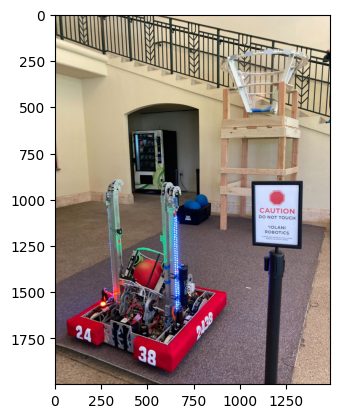

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

# OpenCV uses BGR channel ordering, but matplotlib uses RGB.
# Use this convenience function when plotting.
def as_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def as_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = cv2.imread('2022_robot.jpg')
plt.imshow(as_rgb(img))

# If you wanted a grayscale image you could use...
# plt.imshow(as_gray(img), cmap = 'gray')

## HSV Threshold

You're probably used to seeing colors described by how much red, green, and blue is needed to make that color. This maps well to how we learn colors in school (such as by mixing paints) or how computers display pixels (like the color grids in your monitor) but RGB values don't directly answer higher level questions like "How bright is this pixel".

There are a variety of ways to describe colors, called colorspaces. The [Hue, Saturation, Value colorspace](https://en.wikipedia.org/wiki/HSL_and_HSV) is one particularly relevant to image analysis. Instead of describing an image as how, red, green, and blue it is, it  uses its three namesake values.
* Hue: hue arranges all the colors around a circle, and this value corresponds to the "angle" of the color. See the link for the colorwheel. This is probably the least intuitive of the three.
* Saturation: How intense the color is.
* Value: Effectively how "bright" the color is.


In [2]:
# First, convert the image to the HSV colorspace
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

Now that the image is in the HSV format, we need another function to color the pixels that fall within a certain range.

In [3]:
help(cv2.inRange)

Help on built-in function inRange:

inRange(...)
    inRange(src, lowerb, upperb[, dst]) -> dst
    .   @brief  Checks if array elements lie between the elements of two other arrays.
    .   
    .   The function checks the range as follows:
    .   -   For every element of a single-channel input array:
    .       \f[\texttt{dst} (I)= \texttt{lowerb} (I)_0  \leq \texttt{src} (I)_0 \leq  \texttt{upperb} (I)_0\f]
    .   -   For two-channel arrays:
    .       \f[\texttt{dst} (I)= \texttt{lowerb} (I)_0  \leq \texttt{src} (I)_0 \leq  \texttt{upperb} (I)_0  \land \texttt{lowerb} (I)_1  \leq \texttt{src} (I)_1 \leq  \texttt{upperb} (I)_1\f]
    .   -   and so forth.
    .   
    .   That is, dst (I) is set to 255 (all 1 -bits) if src (I) is within the
    .   specified 1D, 2D, 3D, ... box and 0 otherwise.
    .   
    .   When the lower and/or upper boundary parameters are scalars, the indexes
    .   (I) at lowerb and upperb in the above formulas should be omitted.
    .   @param src firs

`cv2.inRange` needs two array-like objects, `lowerb`, and `upperb`. For a three channel image (H, S, V), both `lowerb` and `upperb` should have three elements. `lowerb` will contain the lower bounds for H, S, V respectively, and `upperb` the upper bounds.

For instance, if you wanted to accept all H values, all S values, but only the upper range of V values...

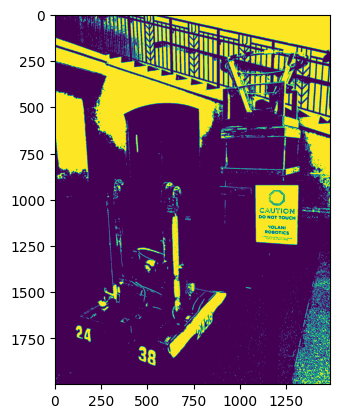

In [4]:
lowerb = (0, 0, 200)
upperb = (255, 255, 255)
thr_img = cv2.inRange(hsv_img, lowerb, upperb)
plt.imshow(thr_img)

Sidebar: `255` is a significant value for images. Images often store individual pixel values as an 8-bit (1 byte) number, and the highest positive integer that can be represented in 8-bits is 255, assuming that no negative numbers are representable. When there are more color channels in the image, such as red, green, blue, each channel will usually get an its own byte. There are however, certain image formats that represent specific channels in a higher resolution than other channels.

Predict and then try for yourself:
* The upper and lower range of the H channel
* The upper and lower range of the S channel

Then:
* Select a set of parameters that maximizes the number of bright pixels on the red ball, and minimizes those from the rest of the image.
  * The bumpers are very similar in color, but it should at least be possible to eliminate the red caution sign.

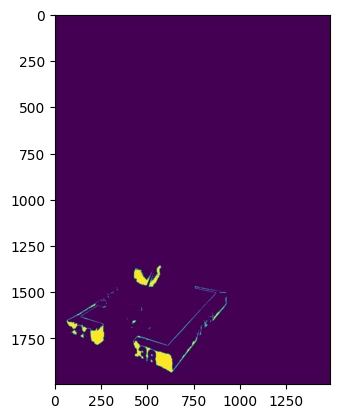

In [5]:
lowerb = (160, 200, 120)
upperb = (180, 255, 170)
thr_img = cv2.inRange(hsv_img, lowerb, upperb)
plt.imshow(thr_img)

## Erode and Dilate

Erode and dilate are closely related and are quite simple. To "erode" an image, replace each pixel value with the minimum pixel value of it an its surrounding neighbors. To "dilate", do the same thing but use the maximum value instead. Erode and Dilate windows are usually odd numbered sizes (like 3x3, 5,5) so that there's a definite center. The boundaries may be ignored, wrapped, padded, etc.

Erode:
```
If the current pixel value is 8, and its neighbors are...
[1, 1, 4]
[5, 8, 7] 
[4, 9, 2]
Assign the value 1 in the resulting image..
```

But as always, an example would explain this best...

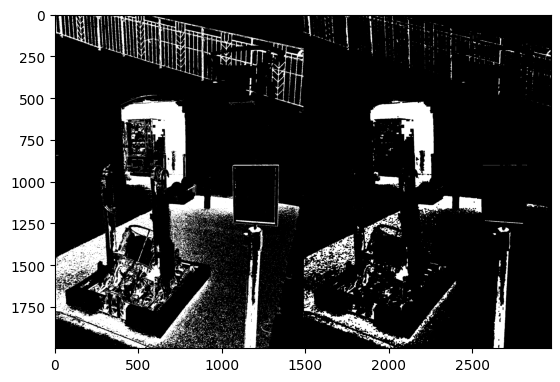

In [6]:
lowerb = (0, 0, 0)
upperb = (255, 80, 100)
thr_img = cv2.inRange(hsv_img, lowerb, upperb)

str_element = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
eroded = cv2.erode(thr_img, str_element)
plt.imshow(cv2.hconcat((thr_img, eroded)), cmap='gray')

Pay special attention to the fence. You can think of erode as a way to eliminate small, narrow features.

There's a new concept embedded in this example, the structuring element. A structuring element is a way of describing the "window" we've seen previously. The moving average from earlier for instance, uses a square window of NxN, and our erode example here uses a rectangular window of 5x5. There's also `cv2.MORPH_CROSS` and `cv2.MORPH_ELLIPSE` too, which are used for considering windows of different shapes, meaning that each of the per-pixel calculations will search a + or O shaped area for the minimum value. 

Try rerunning the previous cell with those other structure elements and see if you can find any notable difference.

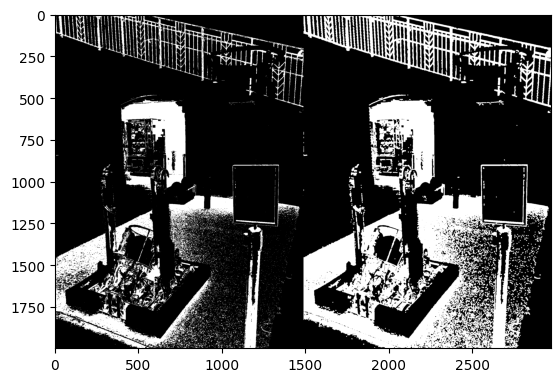

In [7]:
str_element = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
eroded = cv2.dilate(thr_img, str_element)
plt.imshow(cv2.hconcat((thr_img, eroded)), cmap='gray')

Dilate probably doesn't need much explanation. Not well pictured here, but dilate can be used to "join" some objects separated by a thin line, which is useful for some other filters to consume.

Also, note that since erode and dilate use a simple min or max, there's some assumption that your "features" are bright values and your background is dark.

What do you think happens if your filter sets each pixel to the MEDIAN of its neighbors instead of minimum or maximum? What effect will that have on an image, given we already know what the average does?

Also, check out this opencv [tutorial on erode and dilate](https://docs.opencv.org/5.x/dd/dd7/tutorial_morph_lines_detection.html) which shows how they can be used to select only vertical or horizontal lines.

## Blur and Sharpen


This really needs no introduction, but if you go out and look for some OpenCV topics on blur and sharpen, you'll find quite a few variants, and none are simply called "blur" or "sharpen".

First, here's the Gaussian blur. Whereas the moving average filter used all equal weights (such as `[1/3, 1/3, 1/3]` for a window size of 3), the gaussian blur uses hump shaped weights.

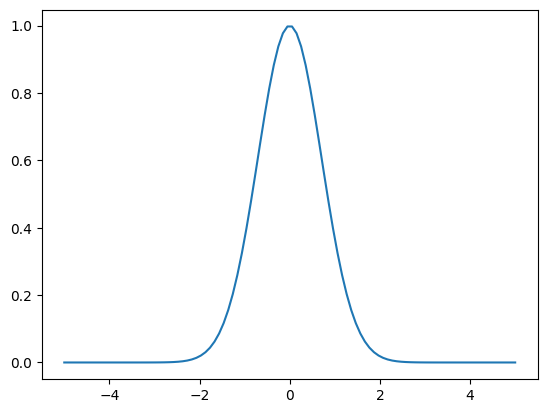

In [8]:
import numpy as np
xs = np.linspace(-5, 5, 100)
ys = np.exp(-1 * (xs**2))
plt.plot(xs, ys)

In [9]:
# parameters
help(cv2.GaussianBlur)

Help on built-in function GaussianBlur:

GaussianBlur(...)
    GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]]) -> dst
    .   @brief Blurs an image using a Gaussian filter.
    .   
    .   The function convolves the source image with the specified Gaussian kernel. In-place filtering is
    .   supported.
    .   
    .   @param src input image; the image can have any number of channels, which are processed
    .   independently, but the depth should be CV_8U, CV_16U, CV_16S, CV_32F or CV_64F.
    .   @param dst output image of the same size and type as src.
    .   @param ksize Gaussian kernel size. ksize.width and ksize.height can differ but they both must be
    .   positive and odd. Or, they can be zero's and then they are computed from sigma.
    .   @param sigmaX Gaussian kernel standard deviation in X direction.
    .   @param sigmaY Gaussian kernel standard deviation in Y direction; if sigmaY is zero, it is set to be
    .   equal to sigmaX, if both sigmas are z

The ksize parameter should be a sequence of two numbers with the height and width of the gaussian window. You typically need a larger window size to achieve "more" blur.

`sigma` is a parameter that describes the distribution of the window. It's often used in statistics when describing the shape of the distribution, but  have a look at the cell below and its slider bars to get an idea of what sigma (roughly represented by `c`) does when you change it.

In [10]:
import ipywidgets as widgets

@widgets.interact(a=1.0, b=0.0, c=1.0)
def gaussian(a, b, c):
    xs = np.linspace(-5, 5, 100)
    ys=  a * np.exp(-1 * ((xs-b)**2) / c**2 )
    plt.plot(xs, ys)

interactive(children=(FloatSlider(value=1.0, description='a', max=3.0, min=-1.0), FloatSlider(value=0.0, descr…

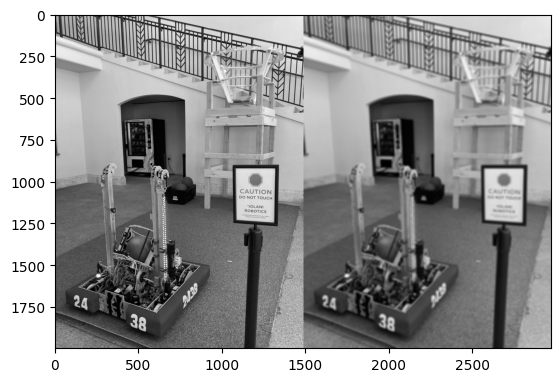

In [11]:
grayimg = as_gray(img)
blurred = cv2.GaussianBlur(grayimg, (15,15), 64.0)

plt.imshow(cv2.hconcat((grayimg, blurred)), cmap='gray')

How about sharpening? Sharpening turns out to be a much more difficult problem. Blur functions inherently lose information; it's what they do. (Think about the average; you can't recover the sequence from the average value). A theoretical perfect sharpen would be the exact inverse of a blur, but given the loss of information some assumptions must be made. Sharpens generally assume that the edges of objects should be reinforced, but features with poor edge definition, or perhaps too much to begin with, often are not significantly improved.

That said, let's look at a common blur algorithm called unsharp mask. The idea here is to isolate the sharp features of the image by subtracting a blurred version from the original, then adding part of that back to the original image. 

In [12]:
@widgets.interact(amt=(0.0, 3.0, 0.1))
def do_usm(amt):
    target = grayimg
    mask = cv2.GaussianBlur(target, (0,0), 2.0)
    
    hf_mask = np.clip((amt * mask), 0, 255).astype(np.uint8)
    
    # y = a*x0 + b*x1 + c
    # np.clip makes sure all values fall between (0,255)
    # We need an explicit conversion to uint8 (byte) type because multiplication
    # by a float automatically promotes the array to float.
    res = np.clip(((1.0 + amt) * target + (-1 * amt) * mask), 0, 255).astype(np.uint8)
    
    plt.imshow(cv2.hconcat(
        (
            target[1000:, 0:1000],
            res[1000:, 0:1000]
        )
    ), cmap='gray')


interactive(children=(FloatSlider(value=1.5, description='amt', max=3.0), Output()), _dom_classes=('widget-int…

Overall this looks like a decent sharpen, the image looks sharper and the noise didn't become too intrusive.

# Problem 1
Below is a function that wraps opencv's SimpleBlobDetector(). You can skip over this for now; we'll focus on how this works in the next session.

In [13]:
def detect(img, det_mask):
    params = cv2.SimpleBlobDetector_Params()
    # params.minThreshold=10
    # params.maxThreshold=200

    params.filterByArea=True
    params.minArea=1000
    params.maxArea=200000
    params.blobColor=255

    detector = cv2.SimpleBlobDetector_create(params)

    keypts = detector.detect(det_mask)
    print(keypts)

    im_w_pts = cv2.drawKeypoints(
        img,
        keypts,
        np.array([]),
        (0,0,255),
        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    return im_w_pts

This takes the starting image, and a processed image called `det_mask` for detection mask. Using any combination of the above filters, process the original image into a mask that detects as many of the whiffle balls as possible. You may not use all of the filters. This particular blob detector is

Use the cell below to start your code. If you run it as is, you'll notice that some of the easiest balls are already correctly detected! I'm sure FRC intentionally designs simple and brightly colored objects to make detection more consistent.

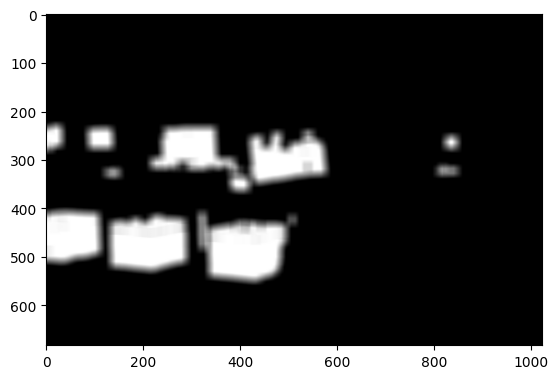

In [14]:
orig = cv2.imread('../0_grip_pipeline/powerup.jpg')
def process(original):
    # Do your custom processing in this function
    hsv_img = cv2.cvtColor(original, cv2.COLOR_BGR2HSV)
    
    thresholded = cv2.inRange(hsv_img, (20,0,150), (50,255,255))
    
    str_element = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    eroded = cv2.erode(thresholded, str_element)
    dilated = cv2.dilate(eroded, str_element)
    
    blurred = cv2.GaussianBlur(dilated, (21, 21), 10**2)
    return blurred

plt.imshow(as_rgb(process(orig)))

(< cv2.KeyPoint 0000024C04084A20>, < cv2.KeyPoint 0000024C040842A0>, < cv2.KeyPoint 0000024C04084360>, < cv2.KeyPoint 0000024C04084030>, < cv2.KeyPoint 0000024C04033A20>)


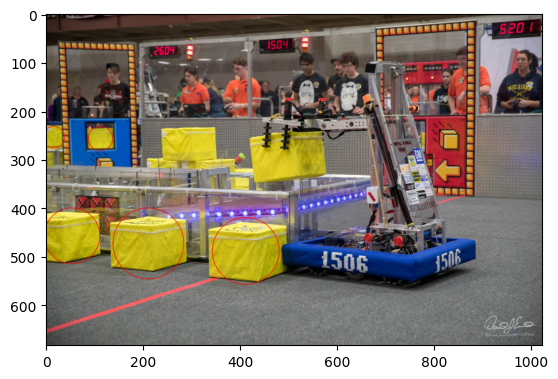

In [15]:
processed = process(orig)

detected = detect(orig, processed)
plt.imshow(as_rgb(detected))